In [1]:
import uproot
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve,auc
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense,Dropout
from sklearn.metrics import roc_curve
from sklearn.preprocessing import StandardScaler
import time
import joblib
import warnings
warnings.filterwarnings('ignore')

pjoin = os.path.join

In [14]:
def load_data(fname,treename):
    events= uproot.open(f"{fname}:{treename}")
    df = events.arrays(library='pd')
    return df

def testDNN(data,modelname,modelfiledir):
    
    X_test=data.values
    
    mymodel=tf.keras.models.load_model(f'{modelfiledir}/best_model_{modelname}.h5')
    mymodel.load_weights(f'{modelfiledir}/best_model_{modelname}.h5')
    scaler=joblib.load(f'{modelfiledir}/scaler_{modelname}.save')
    X_test=scaler.transform(X_test)
    
    y_pred_test = mymodel.predict(X_test,batch_size=100000).ravel()
    
    return y_pred_test
    

In [7]:
inputfile = f"VLLRun2_MVATrainingTree_VLLtau_M400_sample.root"

data = load_data(f'inputData/{inputfile}','Events')

In [9]:
data.head(5)

,index,lep0_flavor,lep0_pt,lep0_phi,lep0_eta,lep0_iso,lep0_tight,lep0_mt,lep0_sip3d,lep0_deepjet,...,PileUpWt_nom,PileUpWt_up,PileUpWt_down,L1PreFireWt_nom,L1PreFireWt_up,L1PreFireWt_down,PDF_up,PDF_down,qcd_scale_up,qcd_scale_down
0,0,13,264.748688,2.848633,1.075439,0.000000,True,83.446205,1.649414,0.008896,...,1.093420,1.056935,1.114694,0.997975,0.997348,0.998601,1.013062,0.988373,1.061951,0.944336
1,1,-13,108.889252,1.380615,-1.175781,0.013995,True,314.169250,1.233398,0.004200,...,0.913632,1.035693,0.769874,0.985078,0.980663,0.989498,1.014282,0.989563,1.039917,0.962341
2,2,-13,76.402939,1.295654,1.503418,0.019031,True,63.952187,8.179688,0.101257,...,0.825609,0.991093,0.656833,0.975132,0.968169,0.982118,1.014771,0.989349,1.056641,0.948578
3,3,13,41.645309,-1.965332,0.175842,0.121089,True,81.294075,5.468750,0.346436,...,0.956212,1.051760,0.831873,0.987080,0.984092,0.990069,1.015259,0.989441,1.046997,0.956604
4,4,13,186.355820,-1.533203,0.201996,0.000000,True,197.142365,1.247070,0.008575,...,0.869226,1.014854,0.710974,0.994007,0.992002,0.996011,1.018372,0.989166,1.060303,0.945801


In [10]:
def createNewColumn(df_):
    df = df_.copy()
    mybin=[0,0.2,0.5,0.8,1.01]
    mybinlabel=[1,2,3,4]
    df.loc[:,'QGjet0cat']=pd.cut(df['deepjetQG_jet0'],bins=mybin,labels=mybinlabel,include_lowest=True)
    df.loc[:,'QGjet1cat']=pd.cut(df['deepjetQG_jet1'],bins=mybin,labels=mybinlabel,include_lowest=True)
    df.loc[:,'avgQGcat'] =pd.cut(df['event_avgQGscore'],bins=mybin,labels=mybinlabel,include_lowest=True)

    return df


In [11]:
feature_list=[
'lep0_pt','lep0_eta','lep0_mt','jet0_pt','jet0_eta','jet0_mt',
'jet1_pt','jet1_eta', 'jet1_mt','dijet_pt','dijet_mt',
'deltaR_jet01','deltaPhi_metjet0', 'deltaPhi_metjet1', 'deltaPhi_metlep0',
'deltaPhi_jet0lep0', 'deltaPhi_jet1lep0',
'deltaPhi_dijetlep0','deltaPhi_metdijet',
'event_MET', 'event_HT', 'n_Jet',
'deepjetQG_jet0', 'deepjetQG_jet1','event_avgQGscore'
]
feature_list.remove('lep0_mt')
feature_list.remove('deepjetQG_jet0')
feature_list.remove('deepjetQG_jet1')
feature_list.remove('event_avgQGscore')
feature_list.append('QGjet0cat')
feature_list.append('QGjet1cat')
feature_list.append('avgQGcat')


data_nn = createNewColumn(data)
data_nn = data_nn[feature_list]

In [18]:
modelname='WJetsInclusivevsVLLtauM400'
modelfiledir='modeldata/'

dnn_score=testDNN(data_nn,modelname,modelfiledir)

In [19]:

data['DNNscore']= dnn_score


In [20]:
data.head(5)

,index,lep0_flavor,lep0_pt,lep0_phi,lep0_eta,lep0_iso,lep0_tight,lep0_mt,lep0_sip3d,lep0_deepjet,...,PileUpWt_up,PileUpWt_down,L1PreFireWt_nom,L1PreFireWt_up,L1PreFireWt_down,PDF_up,PDF_down,qcd_scale_up,qcd_scale_down,DNNscore
0,0,13,264.748688,2.848633,1.075439,0.000000,True,83.446205,1.649414,0.008896,...,1.056935,1.114694,0.997975,0.997348,0.998601,1.013062,0.988373,1.061951,0.944336,0.878806
1,1,-13,108.889252,1.380615,-1.175781,0.013995,True,314.169250,1.233398,0.004200,...,1.035693,0.769874,0.985078,0.980663,0.989498,1.014282,0.989563,1.039917,0.962341,0.997531
2,2,-13,76.402939,1.295654,1.503418,0.019031,True,63.952187,8.179688,0.101257,...,0.991093,0.656833,0.975132,0.968169,0.982118,1.014771,0.989349,1.056641,0.948578,0.719858
3,3,13,41.645309,-1.965332,0.175842,0.121089,True,81.294075,5.468750,0.346436,...,1.051760,0.831873,0.987080,0.984092,0.990069,1.015259,0.989441,1.046997,0.956604,0.654290
4,4,13,186.355820,-1.533203,0.201996,0.000000,True,197.142365,1.247070,0.008575,...,1.014854,0.710974,0.994007,0.992002,0.996011,1.018372,0.989166,1.060303,0.945801,0.990956


## Save the dataframe in a new tree for later use in analysis

In [22]:
ofname = "outputTree_withMVAscore.root"
file = uproot.recreate(ofname)
file['Events']=data
file.compression=uproot.ZLIB(9)

print("filename: ", ofname )
print(f'events/columns: {data.shape}')

filename:  outputTree_withMVAscore.root
events/columns: (60675, 77)



## Read the new tree using uproot and draw score

In [23]:
events = uproot.open(ofname)["Events"]

In [28]:
events.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
index                | int64_t                  | AsDtype('>i8')
lep0_flavor          | int32_t                  | AsDtype('>i4')
lep0_pt              | float                    | AsDtype('>f4')
lep0_phi             | float                    | AsDtype('>f4')
lep0_eta             | float                    | AsDtype('>f4')
lep0_iso             | float                    | AsDtype('>f4')
lep0_tight           | bool                     | AsDtype('bool')
lep0_mt              | float                    | AsDtype('>f4')
lep0_sip3d           | float                    | AsDtype('>f4')
lep0_deepjet         | float                    | AsDtype('>f4')
jet0_pt              | float                    | AsDtype('>f4')
jet0_phi             | float                    | AsDtype('>f4')
jet0_eta             | float                    | AsDtype

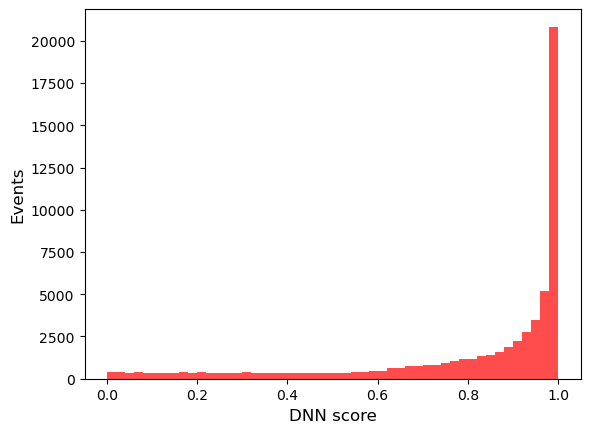

In [40]:

plt.figure()
plt.hist(events['DNNscore'].array(),bins=50,color='red',alpha=0.7)
plt.xlabel('DNN score',fontsize=12)
plt.ylabel('Events',fontsize=12)
plt.show()
